# @Autors  
- ## Djiby BALDE  
- ## Divine Tulomba

# Hate speech dataset from a white supremacist forum 
La base de donnée `Hate speech` est télechargée à partir du site [GitHub](https://github.com/aitor-garcia-p/hate-speech-dataset) de MR. García Pablos. Elle contient 10703 fichiés. Chaque fichié est labellisé soit `hate` ou `noHate`. (les labels et les fichiés sont relié à l'aide de l'indentifiant du ficher).

## Import Libraries

In [1]:
import numpy as np
import pandas as pd

import glob
from glob import iglob
import pandas as pd


In [2]:
import nltk
import os
import re
import math
import operator
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
Stopwords = set(stopwords.words('english'))
wordlemmatizer = WordNetLemmatizer()


# Load Data

In [5]:
# Le chemain de la base
path_text = 'all_files/'
files_text = glob.glob(path_text+'*.txt')

# Recuperer le nom de chaque fichier (identifiant du fichier) et de l'enregristré comme une variable
# On stock d'abord le chemain correspondant dans uns list pour y pouvoir recuperer l'identifiant
path_text = []
for file in files_text:
    path_text.append(file)
    

In [6]:
path_text[:2]

['all_files/13458115_2.txt', 'all_files/13367480_1.txt']

In [4]:
# Enregistrer l'indentifiant dans une colonne 
file_path = pd.DataFrame(path_text, columns=['file_name'])

file_path['file_id'] = file_path['file_name'].str.split('/').str[1].str.split('.').str[0]
file_path.head()

,file_name,file_id
0,all_files/13458115_2.txt,13458115_2
1,all_files/13367480_1.txt,13367480_1
2,all_files/30422449_1.txt,30422449_1
3,all_files/14651837_4.txt,14651837_4
4,all_files/30527903_3.txt,30527903_3


In [7]:
# Importer les fichiés textes
path_text = 'all_files/'
files_text = glob.glob(path_text+'*.txt')

texts = []
for file in files_text:
    texts.append(open(file,'r', encoding="utf-8").readline())


In [8]:
# Mettre les fichiés et leur identifiant dans la table
file_path = file_path['file_id']
hate_speech = pd.concat([file_path, pd.DataFrame(texts,  columns=['text'])], axis=1)

hate_speech.head()

,file_id,text
0,13458115_2,It 's like that at most public boards .
1,13367480_1,I wonder if one of the victims opened the door...
2,30422449_1,Some people believe the Jack O ' Lantern also ...
3,14651837_4,Ready .... GO !!!
4,30527903_3,Thanks !


In [9]:
# Importer table de la variable `label`
annotations = pd.read_csv('annotations_metadata.csv')
annotations.drop(['subforum_id', 'num_contexts'], axis=1, inplace=True)
annotations.head()

,file_id,user_id,label
0,12834217_1,572066,noHate
1,12834217_2,572066,noHate
2,12834217_3,572066,noHate
3,12834217_4,572066,hate
4,12834217_5,572066,noHate


In [16]:
# Melanger les deux tables
hate_speech_df = pd.merge(annotations, hate_speech, how='inner', on='file_id')
hate_speech_df = hate_speech_df.loc[(hate_speech_df.label=='noHate') | (hate_speech_df.label=='hate')]
hate_speech_df = hate_speech_df[['label','text']]

print(hate_speech_df.shape)
hate_speech_df.head()

(10703, 2)


,label,text
0,noHate,"As of March 13th , 2014 , the booklet had been..."
1,noHate,In order to help increase the booklets downloa...
2,noHate,( Simply copy and paste the following text int...
3,hate,Click below for a FREE download of a colorfull...
4,noHate,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...


In [17]:
hate_speech_df.label.unique(), hate_speech_df.shape

(array(['noHate', 'hate'], dtype=object), (10703, 2))

In [18]:
"""
nohate = hate_speech_df.loc[hate_speech_df.label=='noHate'].text
hate = hate_speech_df.loc[hate_speech_df.label=='hate'].text
hate.shape, nohate.shape

hate_speech_df['text'].to_csv(r'hate_nohate/hate_speech.txt', header=None, index=None, sep=',')
nohate.to_csv(r'hate_nohate/nohate.txt', header=None, index=None, sep=',', mode='a')
hate.to_csv(r'hate_nohate/hate.txt', header=None, index=None, sep=',', mode='a')
#speech_file = 'hate_nohate/hate_speech.txt'
#speech_file = open(speech_file , 'r')
#speech_file = speech_file.read()
"""

"\nnohate = hate_speech_df.loc[hate_speech_df.label=='noHate'].text\nhate = hate_speech_df.loc[hate_speech_df.label=='hate'].text\nhate.shape, nohate.shape\n\nhate_speech_df['text'].to_csv(r'hate_nohate/hate_speech.txt', header=None, index=None, sep=',')\nnohate.to_csv(r'hate_nohate/nohate.txt', header=None, index=None, sep=',', mode='a')\nhate.to_csv(r'hate_nohate/hate.txt', header=None, index=None, sep=',', mode='a')\n#speech_file = 'hate_nohate/hate_speech.txt'\n#speech_file = open(speech_file , 'r')\n#speech_file = speech_file.read()\n"

# Text processing

In [19]:
# Replace contractions with their longer forms
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                        "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                        "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                        "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                        "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                        "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                        "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                        "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                        "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                        "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                        "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                        "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                        "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                        "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                        "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                        "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                        "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                        "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                        "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                        "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                        "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                        "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                        "you're": "you are", "you've": "you have"}


In [20]:
hate_speech_df['text_orginal'] = hate_speech_df['text'].copy()

In [21]:
# Nettoyage du text
sentences = []
for sentence in hate_speech_df['text']:
    
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
                       '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    
    sentence = re.sub(space_pattern, ' ', sentence)
    sentence = re.sub(giant_url_regex, 'URLHERE', sentence)
    sentence = re.sub(mention_regex, 'MENTIONHERE', sentence)
    sentence = re.sub(hashtag_regex, 'HASHTAGHERE', sentence)
    
    sentence = re.sub(r"[^A-Za-z0-9^, !. \/'+=]", " ", sentence)
    sentence = re.sub(r"!"," ", sentence)
    sentence = re.sub(r"</s>"," ", sentence)
    sentence = re.sub(r","," ", sentence)
    sentence = re.sub(r"\."," ", sentence)
    sentence = re.sub(r"\/"," ", sentence)
    sentence = re.sub(r"\^"," ^ ", sentence)
    sentence = re.sub(r"\+"," + ", sentence)
    sentence = re.sub(r"\-"," - ", sentence)
    sentence = re.sub(r"\="," = ", sentence)
    sentence = re.sub(r"'"," ", sentence)
    sentence = re.sub(r"(\d+)(k)",r"\g<1>000 ", sentence)
    sentence = re.sub(r":"," : ", sentence)
    sentence = re.sub(r" e g", " eg ", sentence)
    sentence = re.sub(r" b g", " bg ", sentence)
    sentence = re.sub(r" u s "," american ", sentence)
    sentence = re.sub(r"\0s","0", sentence)
    sentence = re.sub(r" 9 11 ","911", sentence)
    sentence = re.sub(r"e - mail","email", sentence)
    sentence = re.sub(r"j k","jk", sentence)
    sentence = re.sub(r"\s{2,}"," ", sentence)
    sentence = re.sub(r'@[A-Za-z0-9]+' ,'', sentence)
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    sentence = re.sub(r'\w(\w)\1{2,}', '', sentence)
    sentence = sentence.lower()
    
    sentence = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in sentence.split(" ")])
    sentence = ' '.join([word for word in sentence.split() if word.isalpha()])
    sentence = ' '.join([word for word in sentence.split() if word.lower() not in Stopwords and len(word)>=3])
    
    sentences.append(sentence.replace('.', '').replace(',', '').replace("'", ""))


In [22]:
# Suprimer les lines qui ne contiennent pas d'information(s)
hate_speech_df['text'] = sentences
hate_speech_df['text'].replace('', np.nan, inplace=True)
hate_speech_df.dropna(axis=0,inplace=True)


In [23]:
hate_speech_df['text'] = hate_speech_df['text'].apply(lambda x : '_START_ '+ x + ' _END_')
text =hate_speech_df['text']
hate_speech_df.shape, len(text)

((10556, 3), 10556)

In [24]:
for i in range(5):
    print("Label:", hate_speech_df['label'][i])
    print("Text:", hate_speech_df['text'][i])
    print("\n")

Label: noHate
Text: _START_ march booklet downloaded times counting _END_


Label: noHate
Text: _START_ order help increase booklets downloads would great stormfronters youtube accounts could display following text description boxes uploaded youtube videos _END_


Label: noHate
Text: _START_ simply copy paste following text youtube videos description boxes _END_


Label: hate
Text: _START_ click free download colorfully illustrated page book zionist engineered intentional destruction western civilization _END_


Label: noHate
Text: _START_ click download green banner link _END_




## Understanding the distribution of the sequences

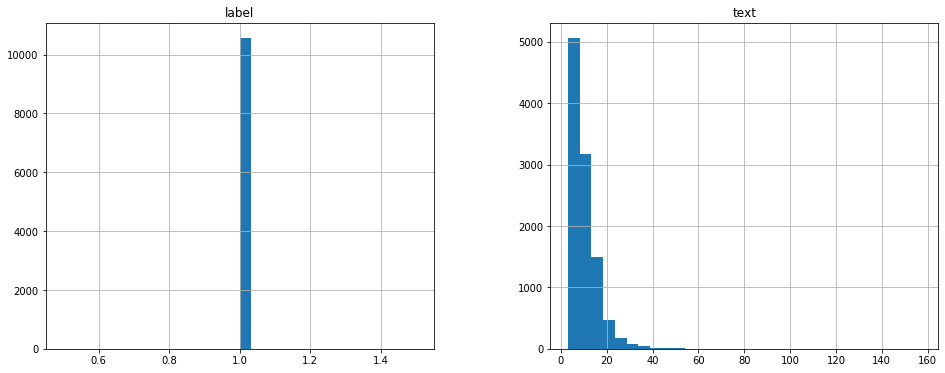

In [26]:
import matplotlib.pyplot as plt
fig, ax= plt.subplots(figsize=(16, 6))

plot_label = []
Plot_text = []

# populate the lists with sentence lengths
for i in hate_speech_df['label']:
    plot_label.append(len(i.split()))

for i in hate_speech_df['text']:
      Plot_text.append(len(i.split()))

length_df = pd.DataFrame({'label':plot_label, 'text':Plot_text})
length_df.hist(bins = 30, ax=ax)

plt.show()


In [69]:
"""from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))

import atexit
import os
import readline
from tkinter import *
from keras.preprocessing.text import Tokenizer"""

In [70]:
"""from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(hate_speech_df['text'],
                                                    hate_speech_df['label'],
                                                    test_size=0.2, random_state=0)

print('Our train and test samples have respectively {} and {} observations'.format(
    X_train.shape[0],X_test.shape[0]))"""

Our train and test samples have respectively 8444 and 2112 observations


In [27]:
import numpy as np
import pandas as pd
from scipy import spatial
from tqdm import tqdm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import fasttext
import tensorflow as tf
import ot

In [28]:
def compute_distribution(document, model):
    distr_A = []
    for word in model:
        if word not in document.split(" "):
            distr_A.append((word, 0))
        else:
            cpt = 0
            for elt in document.split(" "):
                if elt != word:
                    pass
                else:
                    cpt += 1
            distr_A.append((word, cpt))
    cpt = 0
    for elt in document.split(" "):
        if elt not in model:
            cpt += 1

    distribution = [x[1] / float(len(document.split(" ")) - cpt) for x in distr_A]

    return distribution


In [29]:
def Wasserstein_dist_OT(A, B, M, model):
    # Wasserstein distance between documents A and B from fasttext model
    # A and B string where words are spaced by " "
    # model is an object model.words from a fasttext model, ie list of unique words in the corpus (the code below allows A and B to contain words not in model.words)
    # X is the matrix of word embeddings from fasttext

    # Compute a the distribution of words in A
    a = compute_distribution(A, model)

    # Compute b the distribution of words in B
    b = compute_distribution(B, model)

    # solve OT problem with Python OT module
    Wd = ot.emd2(a, b, M)  # this is the exact linear program
    return (Wd)


In [30]:
def Sinkhorn_dist_OT(A, B, M, reg, model):
    # Wasserstein distance between documents A and B from fasttext model
    # A and B string where words are spaced by " "
    # model is an object model.words from a fasttext model, ie list of unique words in the corpus (the code below allows A and B to contain words not in model.words)
    # X is the matrix of word embeddings from fasttext

    # Compute a the distribution of words in A
    a = compute_distribution(A, model)

    # Compute b the distribution of words in B
    b = compute_distribution(B, model)

    # solve OT problem with Python OT module
    Wd = ot.sinkhorn(a, b, M, reg)  # this is the exact linear program
    return (Wd)


In [31]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            
            plt.axhline(y=max_d, c='k')
    return ddata


In [32]:
def write_excel(df, out='df_out.xlsx', idx=False):
    """
    exports a Dataframe as excel file
    :param df: Dataframe to export
    :param out: excel file to save
    :param idx: if False, the index column is not saved
    :return: nothing
    """
    writer = pd.ExcelWriter(out, engine='xlsxwriter', options={'strings_to_urls': False})
    df.to_excel(writer, index=idx)
    writer.save()
    writer.close()


In [33]:
# Fasttext training from scratch
n = len(text) # size of training

text.to_csv('corpus.txt', index=False, header=False) # csv for training fasttext
print('Start FastText training...')

model = fasttext.train_unsupervised("corpus.txt", model='cbow')
print('FastText training done !')

model.save_model("model.bin")


Start FastText training...
FastText training done !


In [34]:
# dictionnary of embedding vectors :key = word and values = vector
embedding = {}
for w in model.words:
    embedding[w] = model[w]


In [35]:
emb_df = pd.DataFrame.from_dict(embedding)
file_out = 'embeddings.xlsx'
write_excel(emb_df.transpose(), out=file_out, idx=True)


In [36]:
emb_df.head()

,_START_,_END_,</s>,white,like,people,one,would,get,youtube,...,lee,derren,assassin,motorcycle,serbia,forces,grammar,fairly,goverment,organizations
0,-0.195662,-0.187533,-0.209837,-0.216218,-0.200612,-0.203405,-0.232055,-0.191751,-0.240920,-0.202528,...,-0.137712,-0.175137,-0.141317,-0.123521,-0.132436,-0.210690,-0.126167,-0.185177,-0.184130,-0.187515
1,-0.188015,-0.184522,-0.217309,-0.192430,-0.193015,-0.189302,-0.224321,-0.185145,-0.225539,-0.192239,...,-0.132265,-0.167734,-0.132162,-0.118536,-0.127448,-0.199912,-0.119144,-0.177612,-0.169682,-0.172875
2,-0.253379,-0.244515,-0.283417,-0.275594,-0.259830,-0.261412,-0.305334,-0.250637,-0.306460,-0.259753,...,-0.180937,-0.228343,-0.177194,-0.160049,-0.171292,-0.275525,-0.162833,-0.237205,-0.235756,-0.240746
3,-0.300109,-0.294591,-0.336304,-0.317308,-0.306327,-0.305097,-0.360208,-0.295704,-0.366999,-0.305740,...,-0.211382,-0.264373,-0.212172,-0.191157,-0.204018,-0.318829,-0.192456,-0.282064,-0.276494,-0.282865
4,-0.277045,-0.273632,-0.309296,-0.295997,-0.286099,-0.283323,-0.340883,-0.274093,-0.338166,-0.287141,...,-0.195371,-0.250218,-0.195212,-0.178292,-0.189052,-0.298659,-0.180708,-0.260988,-0.255161,-0.259920


In [37]:
# words embedding matrix
X = np.array([x.tolist() for x in embedding.values() if x.shape[0] != 1])


In [38]:
# Coast matrix calculus (distances between words)
print('Start coast matrix calculus')
C_light = spatial.distance.pdist(X) # condensed list of length n*(n-1)/2 of distances between the n words wi and wj, i smaller than j
dim = len(model.words)
vals = C_light
Z = np.zeros([dim,dim], dtype=np.double)
Z[np.triu_indices(dim, k=1)] = vals
Z = Z + Z.T
Z[np.diag_indices(dim)] = 0

distance = Z
print('Coast matrix calculated')
M = np.array(distance)


Start coast matrix calculus
Coast matrix calculated


In [39]:
# histograms for each document (4 minutes for 6532 docs)
try:
    docs_histogs = []
    for doc in tqdm(text, total=text.shape[0]):
        docs_histogs.append(compute_distribution(doc, model.words))
except ZeroDivisionError:
    pass

100%|██████████| 10556/10556 [00:48<00:00, 219.75it/s]


In [40]:
# distance between 2 documents
a = docs_histogs[0]
b = docs_histogs[1]
Wd = ot.emd2(a, b, M)  # this is the exact linear program


In [41]:
"""####################################################################################################
# compute the WMD matrix from the set of documents in the train
m = 100 # small matrix size for testing
res = [[Wasserstein_dist_OT(x, y, M, model.words) for x in tqdm(hate_speech_df.iloc[:m, -1])] for y in hate_speech_df.iloc[:m, -1]]
D = np.array(res)

#m = 10 # small matrix size for testing
#reg = 1
#res = [[Sinkhorn_dist_OT(x, y, M, reg, model.words) for x in tqdm(hate_speech_df.iloc[:m, 1])] for y in hate_speech_df.iloc[:m, 1]]
#D = np.array(res)
"""

'####################################################################################################\n# compute the WMD matrix from the set of documents in the train\nm = 100 # small matrix size for testing\nres = [[Wasserstein_dist_OT(x, y, M, model.words) for x in tqdm(hate_speech_df.iloc[:m, -1])] for y in hate_speech_df.iloc[:m, -1]]\nD = np.array(res)\n\n#m = 10 # small matrix size for testing\n#reg = 1\n#res = [[Sinkhorn_dist_OT(x, y, M, reg, model.words) for x in tqdm(hate_speech_df.iloc[:m, 1])] for y in hate_speech_df.iloc[:m, 1]]\n#D = np.array(res)\n'

In [42]:
m = 100
res = [] # Matrix triangulaire
i = 0
for x in hate_speech_df.iloc[:m, 1]:
    for y in tqdm(hate_speech_df.iloc[i:m, 1]):
        res.append(Wasserstein_dist_OT(x, y, M, model.words))
    i = i + 1

100%|██████████| 1/1 [00:00<00:00, 41.01it/s]


In [49]:
####################################################################################################
# Plotting dendogram
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt


In [50]:
linked = linkage(res, 'ward')
labelList = range(len(res))


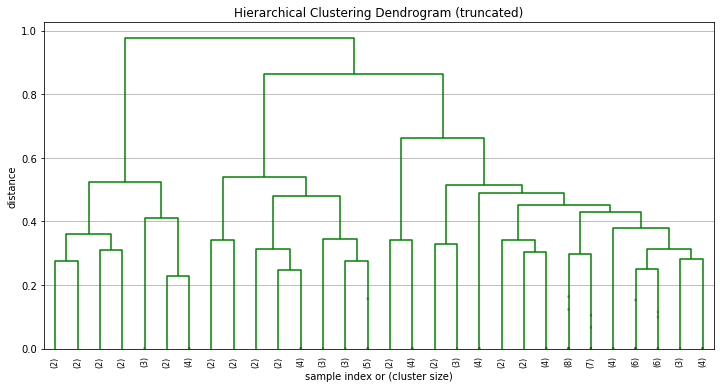

In [51]:
# plt.figure(figsize=(10, 7))
# dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending', show_leaf_counts=True)
# plt.savefig(pwd + 'Dendo.png')
# plt.show()

plt.figure(figsize=(12, 6))
plt.grid(which='both', axis='y')
fancy_dendrogram(
    linked,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True,
    annotate_above=8,
    max_d=9.5,
)
#plt.savefig(pwd + 'Dendo.png')
plt.show()

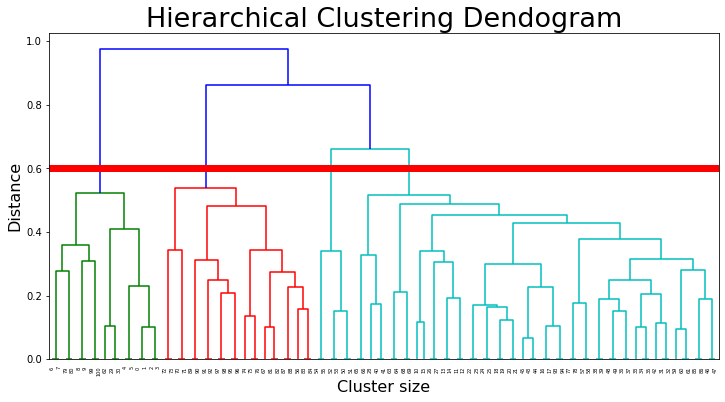

In [52]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(12, 6))

plt.title("Customer Dendograms")
dend = shc.dendrogram(linked)
plt.plot([linked.min(), 50000],[0.6, 0.6], c='r', linewidth=7)
plt.title('Hierarchical Clustering Dendogram', fontsize=27)
plt.xlabel('Cluster size', fontsize=16); plt.ylabel('Distance', fontsize=16)
plt.show()

In [72]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
cluster.fit_predict(linked)

array([0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 3, 2, 0, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

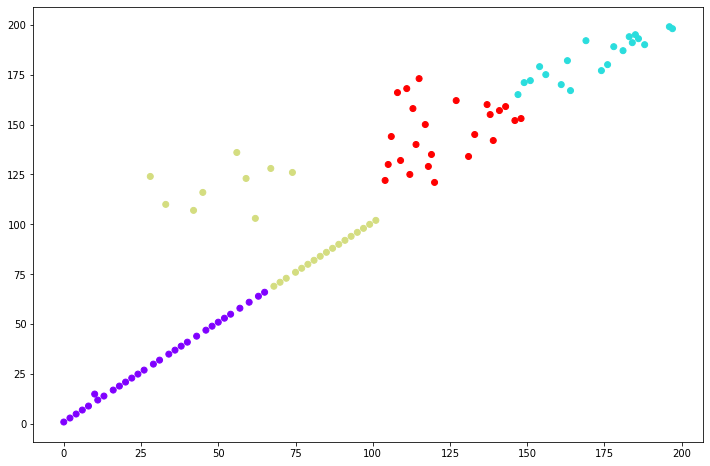

In [73]:
plt.figure(figsize=(12, 8))

plt.scatter(linked[:,0], linked[:,1], c=cluster.labels_, cmap='rainbow')
plt.show()

In [74]:
cluste_df = hate_speech_df.iloc[:m, :].copy()
cluste_df['cluster'] = cluster.fit_predict(linked).copy()

In [75]:
cluste_df.head(10)

,label,text,text_orginal,cluster
0,noHate,_START_ march booklet downloaded times countin...,"As of March 13th , 2014 , the booklet had been...",0
1,noHate,_START_ order help increase booklets downloads...,In order to help increase the booklets downloa...,0
2,noHate,_START_ simply copy paste following text youtu...,( Simply copy and paste the following text int...,0
3,hate,_START_ click free download colorfully illustr...,Click below for a FREE download of a colorfull...,2
4,noHate,_START_ click download green banner link _END_,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...,0
5,noHate,_START_ booklet updated feb _END_,"Booklet updated on Feb. 14th , 2014 .",2
6,noHate,_START_ downloads _END_,"( Now with over 18,300 Downloads. )",0
7,noHate,_START_ pdf file urlhere docx watch hour video...,PDF file : http://www.mediafire.com/download/7...,0
8,noHate,_START_ simply copy text links paste descripti...,Then why not simply copy this text ( & links )...,2
9,noHate,_START_ thank advance download youtube descrip...,Thank you in advance. : ) Download the youtube...,0


In [76]:
cluste_df['text_orginal'][3]

'Click below for a FREE download of a colorfully illustrated 132 page e-book on the Zionist-engineered INTENTIONAL destruction of Western civilization .'

In [77]:
# Tableau croisé
cross_tab = pd.crosstab(cluste_df.label, cluste_df.cluster, margins=True, margins_name='Total')
cross_tab

cluster,0,1,2,3,Total
label,,,,,
hate,3,0,4,4,11
noHate,27,20,22,20,89
Total,30,20,26,24,100


In [80]:
# Tableau croisé avec pourcentage en colonne
pd.crosstab(cluste_df.label, cluste_df.cluster).apply(lambda r: np.round(100*r/r.sum(),2), axis=0)

cluster,0,1,2,3
label,,,,
hate,10.0,0.0,15.38,16.67
noHate,90.0,100.0,84.62,83.33


In [78]:
# Tableau croisé avec pourcentage en ligne
pd.crosstab(cluste_df.label, cluste_df.cluster).apply(lambda r: np.round(100*r/r.sum(),2), axis=1)

cluster,0,1,2,3
label,,,,
hate,27.27,0.00,36.36,36.36
noHate,30.34,22.47,24.72,22.47


# Modelization

In [11]:
from attention import AttentionLayer
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

from pickle import dump
from pickle import load


Using TensorFlow backend.


In [22]:
max_len_label = 80 
max_len_text = 10

In [31]:
# Split the dataset into into a training (90%) and validation set (10%).
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(hate_speech_df['text'],
                                            hate_speech_df['label'],
                                            test_size=0.2, random_state=0, shuffle=True) 

## Preparing the Tokenizer

In [32]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr = x_tokenizer.texts_to_sequences(x_tr) 
x_val = x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr = pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val = pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size = len(x_tokenizer.word_index) +1

In [33]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr = y_tokenizer.texts_to_sequences(y_tr) 
y_val = y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr = pad_sequences(y_tr, maxlen=max_len_label, padding='post')
y_val = pad_sequences(y_val, maxlen=max_len_label, padding='post')

y_voc_size = len(y_tokenizer.word_index) +1

## Model building

In [34]:
from keras import backend as K 
K.clear_session() 
latent_dim = 20 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 20)       251480      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 10, 20), (No 3280        embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [35]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [36]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [37]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                  epochs=10,callbacks=[es], batch_size=512,
                  validation_data=([x_val,y_val[:,:-1]],y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 8444 samples, validate on 2111 samples
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
8444/8444 [==============================] - 13s 2ms/sample - loss: 0.6740 - val_loss: 0.1614
Epoch 2/10
8444/8444 [==============================] - 4s 441us/sample - loss: 0.0640 - val_loss: 0.0164
Epoch 3/10
8444/8444 [==============================] - 4s 434us/sample - loss: 0.0098 - val_loss: 0.0048
Epoch 4/10
8444/8444 [==============================] - 4s 463us/sample - loss: 0.0033 - val_loss: 0.0020
Epoch 5/10
8444/8444 [==============================] - 4s 452us/sample - loss: 0.0014 - val_loss: 8.9482e-04
Epoch 6/10
8444/8444 [==============================] - 4s 455us/sample - loss: 6.5920e-04 - val_loss: 4.2753e-04
Epoch 7/10
8444/8444 [==============================] - 4s 450us/sample - loss: 3.1725e-04 - val_loss: 2.0862e-04
Epoch 8/10
8444/8444 [==============================] - 4s 441us/sample - loss: 1.5512e-04 - val_

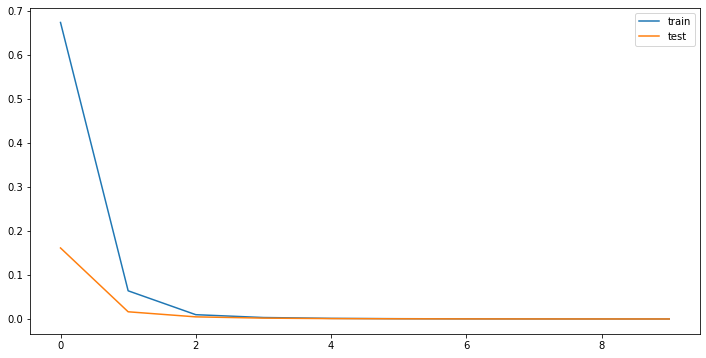

In [38]:
import matplotlib.pyplot as plt

fig, ax= plt.subplots(figsize=(12, 6))

ax.plot(history.history['loss'], label='train') 
ax.plot(history.history['val_loss'], label='test') 
ax.legend(); plt.show()


In [39]:
reverse_target_word_index = y_tokenizer.index_word 
reverse_source_word_index = x_tokenizer.index_word 
target_word_index = y_tokenizer.word_index


In [40]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])


In [41]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [42]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString = newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if (i!=0):
            newString = newString+reverse_source_word_index[i]+' '
    return newString
